# Module 6: Airlines

In this section, we’ll use a different scenario to illustrate the analysis of US airport data with Spark.

In [11]:
from pyspark.sql.types import *
from graphframes import *
from neo4j import GraphDatabase
from pyspark.sql import functions as F
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

## Connect to Spark

The following code will create a SparkContext that we'll use to connect to Spark:

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## Analyzing Airline Flight Data with Apache Spark

The US Bureau of Transportation Statistics makes available a significant amount of transportation information. For our analysis, we’ll use their May 2018 air travel on-time performance data, which includes flights originating and ending in the United States in that month. To add more detail about airports, such as location information, we’ll also load data from a separate source, OpenFlights.


### Importing the Data into Apache Spark

Let’s load the data in Spark.


In [3]:
nodes = spark.read.csv("data/airports.csv", header=False)
cleaned_nodes = (nodes.select("_c1", "_c3", "_c4", "_c6", "_c7")
                 .filter("_c3 = 'United States'")
                 .withColumnRenamed("_c1", "name")
                 .withColumnRenamed("_c4", "id")
                 .withColumnRenamed("_c6", "latitude")
                 .withColumnRenamed("_c7", "longitude")
                 .drop("_c3"))
cleaned_nodes = cleaned_nodes[cleaned_nodes["id"] != "\\N"]

relationships = spark.read.csv("data/188591317_T_ONTIME.csv", header=True)
cleaned_relationships = (relationships
                         .select("ORIGIN", "DEST", "FL_DATE", "DEP_DELAY",
                                 "ARR_DELAY", "DISTANCE", "TAIL_NUM", "FL_NUM",
                                 "CRS_DEP_TIME", "CRS_ARR_TIME",
                                 "UNIQUE_CARRIER")
                         .withColumnRenamed("ORIGIN", "src")
                         .withColumnRenamed("DEST", "dst")
                         .withColumnRenamed("DEP_DELAY", "deptDelay")
                         .withColumnRenamed("ARR_DELAY", "arrDelay")
                         .withColumnRenamed("TAIL_NUM", "tailNumber")
                         .withColumnRenamed("FL_NUM", "flightNumber")
                         .withColumnRenamed("FL_DATE", "date")
                         .withColumnRenamed("CRS_DEP_TIME", "time")
                         .withColumnRenamed("CRS_ARR_TIME", "arrivalTime")
                         .withColumnRenamed("DISTANCE", "distance")
                         .withColumnRenamed("UNIQUE_CARRIER", "airline")
                         .withColumn("deptDelay", F.col("deptDelay").cast(FloatType()))
                         .withColumn("arrDelay", F.col("arrDelay").cast(FloatType()))
                         .withColumn("time", F.col("time").cast(IntegerType()))
                         .withColumn("arrivalTime",F.col("arrivalTime").cast(IntegerType())))
g = GraphFrame(cleaned_nodes, cleaned_relationships)

In [4]:
airlines_reference = (spark.read.csv("data/airlines.csv")
                      .select("_c1", "_c3")
                      .withColumnRenamed("_c1", "name")
                      .withColumnRenamed("_c3", "code"))
airlines_reference = airlines_reference[airlines_reference["code"] != "null"]

In [20]:
display("Nodes", g.vertices.count())
display("Relationships", g.edges.count())

'Nodes'

1333

'Relationships'

616529

## Popular Airports

Triangle Count determines the number of triangles passing through each node in the graph. A triangle is a set of three nodes,where each node has a relationship to all other nodes.

In [7]:
airports_degree = g.outDegrees.withColumnRenamed("id", "oId")
full_airports_degree = (airports_degree
                        .join(g.vertices, airports_degree.oId == g.vertices.id)
                        .sort("outDegree", ascending=False)
                        .select("id", "name", "outDegree"))

full_airports_degree.show(n=10, truncate=False)

+---+------------------------------------------------+---------+
|id |name                                            |outDegree|
+---+------------------------------------------------+---------+
|ATL|Hartsfield Jackson Atlanta International Airport|33837    |
|ORD|Chicago O'Hare International Airport            |28338    |
|DFW|Dallas Fort Worth International Airport         |23765    |
|CLT|Charlotte Douglas International Airport         |20251    |
|DEN|Denver International Airport                    |19836    |
|LAX|Los Angeles International Airport               |19059    |
|PHX|Phoenix Sky Harbor International Airport        |15103    |
|SFO|San Francisco International Airport             |14934    |
|LGA|La Guardia Airport                              |14709    |
|IAH|George Bush Intercontinental Houston Airport    |14407    |
+---+------------------------------------------------+---------+
only showing top 10 rows



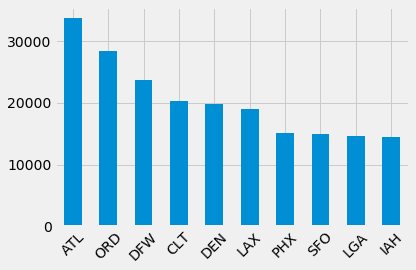

In [15]:
plt.style.use('fivethirtyeight')
ax = (full_airports_degree
      .toPandas()
      .head(10)
      .plot(kind='bar', x='id', y='outDegree', legend=None))
ax.xaxis.set_label_text("")
plt.xticks(rotation=45)
plt.tight_layout()

It’s quite striking how suddenly the number of flights drops off. Denver International Airport (DEN), the fifth most popular airport, has just over half as many outgoing fights as Hartsfield Jackson Atlanta International Airport (ATL), in first place.

## Delays from ORD

In [16]:
delayed_flights = (g.edges
                   .filter("src = 'ORD' and deptDelay > 0")
                   .groupBy("dst")
                   .agg(F.avg("deptDelay"), F.count("deptDelay"))
                   .withColumn("averageDelay", F.round(F.col("avg(deptDelay)"), 2))
                   .withColumn("numberOfDelays", F.col("count(deptDelay)")))

(delayed_flights
 .join(g.vertices, delayed_flights.dst == g.vertices.id)
 .sort(F.desc("averageDelay"))
 .select("dst", "name", "averageDelay", "numberOfDelays")
 .show(n=10, truncate=False))

+---+-------------------------------------------+------------+--------------+
|dst|name                                       |averageDelay|numberOfDelays|
+---+-------------------------------------------+------------+--------------+
|CKB|North Central West Virginia Airport        |145.08      |12            |
|OGG|Kahului Airport                            |119.67      |9             |
|MQT|Sawyer International Airport               |114.75      |12            |
|MOB|Mobile Regional Airport                    |102.2       |10            |
|TTN|Trenton Mercer Airport                     |101.18      |17            |
|AVL|Asheville Regional Airport                 |98.5        |28            |
|ISP|Long Island Mac Arthur Airport             |94.08       |13            |
|ANC|Ted Stevens Anchorage International Airport|83.74       |23            |
|BTV|Burlington International Airport           |83.2        |25            |
|CMX|Houghton County Memorial Airport           |79.18       |17

In [21]:
from_expr = 'id = "ORD"'
to_expr = 'id = "CKB"'
ord_to_ckb = g.bfs(from_expr, to_expr)
ord_to_ckb = ord_to_ckb.select(
    F.col("e0.date"),
    F.col("e0.time"),
    F.col("e0.flightNumber"),
    F.col("e0.deptDelay"))

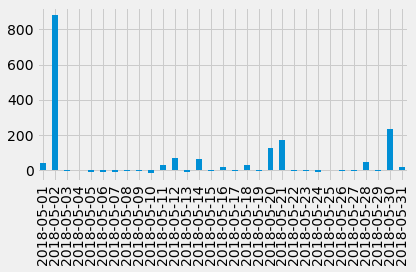

In [22]:
ax = (ord_to_ckb
      .sort("date")
      .toPandas()
      .plot(kind='bar', x='date', y='deptDelay', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

## Bad Day at SFO

Let’s consider delays at an airport known for fog-related “low ceiling” issues: San Francisco International Airport (SFO).

We'll look at [_motifs_](https://github.com/graphframes/graphframes/blob/master/docs/user-guide.md#motif-finding), which are recurrent subgraphs or patterns. Let’s use motifs to find the most-delayed flights going into and out of SFO on May 11, 2018. The following code will find these delays:

In [30]:
motifs = (g.find("(a)-[ab]->(b); (b)-[bc]->(c)")
          .filter("""(b.id = 'SFO') and
          (ab.date = '2018-05-11' and bc.date = '2018-05-11') and
          (ab.arrDelay > 30 or bc.deptDelay > 30) and
          (ab.flightNumber = bc.flightNumber) and
          (ab.airline = bc.airline) and
          (ab.time < bc.time)"""))
motifs.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   a|                  ab|                   b|                  bc|                   c|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|[Arcata Airport, ...|[ACV, SFO, 2018-0...|[San Francisco In...|[SFO, RDM, 2018-0...|[Roberts Field, R...|
|[Bob Hope Airport...|[BUR, SFO, 2018-0...|[San Francisco In...|[SFO, PHX, 2018-0...|[Phoenix Sky Harb...|
|[Portland Interna...|[PDX, SFO, 2018-0...|[San Francisco In...|[SFO, BUR, 2018-0...|[Bob Hope Airport...|
|[Denver Internati...|[DEN, SFO, 2018-0...|[San Francisco In...|[SFO, BUR, 2018-0...|[Bob Hope Airport...|
|[Bob Hope Airport...|[BUR, SFO, 2018-0...|[San Francisco In...|[SFO, PDX, 2018-0...|[Portland Interna...|
|[Portland Interna...|[PDX, SFO, 2018-0...|[San Francisco In...|[SFO, DEN, 2018-0...|[Denver Internati...|
|[Hartsfield Jacks...|[ATL, SFO, 2018

In [24]:
result = (motifs.withColumn("delta", motifs.bc.deptDelay - motifs.ab.arrDelay)
          .select("ab", "bc", "delta")
          .sort("delta", ascending=False))

result.select(
    F.col("ab.src").alias("a1"),
    F.col("ab.time").alias("a1DeptTime"),
    F.col("ab.arrDelay"),
    F.col("ab.dst").alias("a2"),
    F.col("bc.time").alias("a2DeptTime"),
    F.col("bc.deptDelay"),
    F.col("bc.dst").alias("a3"),
    F.col("ab.airline"),
    F.col("ab.flightNumber"),
    F.col("delta")
).show()

+---+----------+--------+---+----------+---------+---+-------+------------+-----+
| a1|a1DeptTime|arrDelay| a2|a2DeptTime|deptDelay| a3|airline|flightNumber|delta|
+---+----------+--------+---+----------+---------+---+-------+------------+-----+
|PDX|      1130|   -18.0|SFO|      1350|    178.0|BUR|     WN|        1454|196.0|
|ACV|      1755|    -9.0|SFO|      2235|     64.0|RDM|     OO|        5700| 73.0|
|BWI|       700|    -3.0|SFO|      1125|     49.0|IAD|     UA|         753| 52.0|
|ATL|       740|    40.0|SFO|      1110|     77.0|SAN|     UA|        1900| 37.0|
|BUR|      1405|    25.0|SFO|      1600|     39.0|PDX|     WN|         157| 14.0|
|DTW|       835|    34.0|SFO|      1135|     44.0|DTW|     DL|         745| 10.0|
|DEN|      1830|    25.0|SFO|      2045|     33.0|BUR|     WN|        1783|  8.0|
|PDX|      1855|   119.0|SFO|      2120|    117.0|DEN|     WN|        5789| -2.0|
|BUR|      2025|    31.0|SFO|      2230|     11.0|PHX|     WN|        1585|-20.0|
+---+----------+

The worst offender, WN 1454, is shown in the top row; it arrived early but departed almost three hours late. We can also see that there are some negative values in the arrDelay column; this means that the flight into SFO was early.

Also notice that some flights, such as WN 5789 and WN 1585, made up time while on the ground in SFO, as shown with a negative delta.

## Interconnected Airports by Airline

Now let’s say we’ve traveled a lot, and those frequent flyer points we’re determined to use to see as many destinations as efficiently as possible are soon to expire. If we start from a specific US airport, how many different airports can we visit and come back to the starting airport using the same airline?

In [31]:
airlines = (g.edges
            .groupBy("airline")
            .agg(F.count("airline").alias("flights"))
            .sort("flights", ascending=False))

full_name_airlines = (airlines_reference
                      .join(airlines, airlines.airline == airlines_reference.code)
                      .select("code", "name", "flights"))

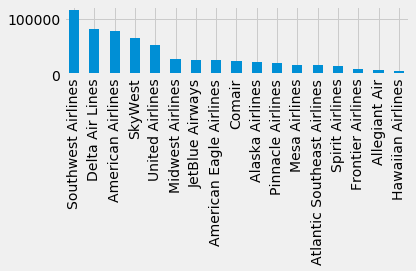

In [32]:
ax = (full_name_airlines.toPandas()
      .plot(kind='bar', x='name', y='flights', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

Now let’s write a function that uses the Strongly Connected Components algorithm to find airport groupings for each airline where all the airports have flights to and from all the other airports in that group:

In [33]:
def find_scc_components(g, airline):
    # Create a subgraph containing only flights on the provided airline
    airline_relationships = g.edges[g.edges.airline == airline]
    airline_graph = GraphFrame(g.vertices, airline_relationships)
    
    # Calculate the Strongly Connected Components
    scc = airline_graph.stronglyConnectedComponents(maxIter=10)
    
    # Find the size of the biggest component and return that
    return (scc
            .groupBy("component")
            .agg(F.count("id").alias("size"))
            .sort("size", ascending=False)
            .take(1)[0]["size"])

In [34]:
# Calculate the largest strongly connected component for each airline
airline_scc = [(airline, find_scc_components(g, airline))
               for airline in airlines.toPandas()["airline"].tolist()]
airline_scc_df = spark.createDataFrame(airline_scc, ['id', 'sccCount'])

# Join the SCC DataFrame with the airlines DataFrame so that we can show
# the number of flights an airline has alongside the number of
# airports reachable in its biggest component
airline_reach = (airline_scc_df
                 .join(full_name_airlines, full_name_airlines.code == airline_scc_df.id)
                 .select("code", "name", "flights", "sccCount")
                 .sort("sccCount", ascending=False))

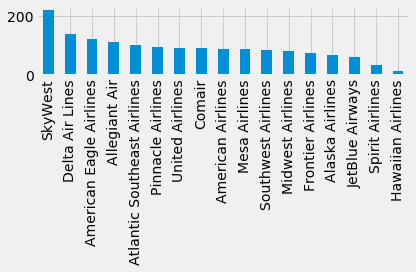

In [35]:
ax = (airline_reach.toPandas()
      .plot(kind='bar', x='name', y='sccCount', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

Now let’s say most of the frequent flyer points we have are with Delta Airlines (DL). Can we find airports that form communities within the network for that particular airline carrier?

In [36]:
airline_relationships = g.edges.filter("airline = 'DL'")
airline_graph = GraphFrame(g.vertices, airline_relationships)
clusters = airline_graph.labelPropagation(maxIter=10)
(clusters
 .sort("label")
 .groupby("label")
 .agg(F.collect_list("id").alias("airports"), F.count("id").alias("count"))
 .sort("count", ascending=False)
 .show(truncate=70, n=10))

+-------------+----------------------------------------------------------------------+-----+
|        label|                                                              airports|count|
+-------------+----------------------------------------------------------------------+-----+
|1606317768706|[IND, ORF, ATW, RIC, TRI, XNA, ECP, AVL, JAX, SYR, BHM, GSO, MEM, C...|   89|
|1219770712067|[GEG, SLC, DTW, LAS, SEA, BOS, MSN, SNA, JFK, TVC, LIH, JAC, FLL, M...|   53|
|  42949672960|                                                                 [FOD]|    1|
|  42949672963|                                                                 [MIC]|    1|
|  42949672962|                                                                 [GTF]|    1|
|            0|                                                                 [BGM]|    1|
|  42949672964|                                                                 [MRN]|    1|
|  42949672965|                                                       

In [38]:
all_flights = g.degrees.withColumnRenamed("id", "aId")

(clusters
 .filter("label=1606317768706")
 .join(all_flights, all_flights.aId == clusters.id)
 .sort("degree", ascending=False)
 .select("id", "name", "degree")
 .show(truncate=False))

+---+------------------------------------------------------------+------+
|id |name                                                        |degree|
+---+------------------------------------------------------------+------+
|DFW|Dallas Fort Worth International Airport                     |47514 |
|CLT|Charlotte Douglas International Airport                     |40495 |
|IAH|George Bush Intercontinental Houston Airport                |28814 |
|EWR|Newark Liberty International Airport                        |25131 |
|PHL|Philadelphia International Airport                          |20804 |
|BWI|Baltimore/Washington International Thurgood Marshall Airport|18989 |
|MDW|Chicago Midway International Airport                        |15178 |
|BNA|Nashville International Airport                             |12455 |
|DAL|Dallas Love Field                                           |12084 |
|IAD|Washington Dulles International Airport                     |11566 |
|STL|Lambert St Louis International Ai